# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №1 - Метод k-средних, предобработка признаков


###### <hr\>
**Общая информация**

**Срок сдачи:** 6 марта 2017, 06:00 <br\>
**Штраф за опоздание:** -2 балла после 06:00 6 марта, -4 балла после 06:00 13 марта, -6 баллов после 06:00 20 марта

При отправлении ДЗ указывайте фамилию в названии файла<br\>

Используйте данный Ipython Notebook при оформлении домашнего задания.
<hr\>

# Первое задание - указать фамилию в имени файла

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

# Пролог: Модуль sklearn
На наших практических занятиях мы будем использовать [sklearn](http://scikit-learn.org/stable/index.html) (scikit-learn) - наиболее популярный модуль для работы с методами машинного обучения и анализа данных.

Этот модуль регулярно обновляется, расширяется и сопровождается примерами использования тех или иных методов. Помимо самих алгоритмов (например k-средних или линейной регрессии) в нем есть множество вспомогательных функций по работе с данными.

# Туториал: Работа с различными типами признаков

Вспомним какие типы признаков могут встретится при описании объектов исследования и как их представить в доступной для обработки компьтером форме

Типы признаков мы будем рассматривать на примере довольно популярного набора данных [titanic](https://www.kaggle.com/c/titanic/download/train.csv) - информации о выживаемости пассажиров после известной трагедии корабля Titanic.

In [2]:
df_titanic = pd.read_csv('train.csv', sep=',').dropna()
df_titanic.head()

OSError: File b'train.csv' does not exist

## Бинарные признаки
Это признаки с двумя возможными значениями
* Пол (мужской, женский)
* Выжил (да, нет)

На вход в алгоритмы обычно подаются в виде значений `{0, 1}` (реже в виде `{-1, 1}`)

In [ ]:
# Здесь все нормально
df_titanic.Survived.value_counts()

In [ ]:
# Тут стоит выполнить переобознаение
df_titanic.Sex.value_counts()

In [ ]:
# Например так
df_titanic.Sex = df_titanic.Sex.replace({'male': 0, 'female': 1})
df_titanic.Sex.value_counts()

## Вещественные признаки

* Возраст
* Сумма, потраченная на билет
* Количество родственников на борту

Как правило остаются в том же виде или выполняется **нормализация** признаков, т.е. переход к одинаковой шкале, например:

* $\tilde{x} = \frac{x - \text{mean}(x)}{\text{std}(x)}$
* $\tilde{x} = \frac{x - \text{min}(x)}{\text{max}(x) - \text{min}(x)}$

## Категориальные признаки

Принимают значения из *неупорядоченного* множества

* Порт погрузки (C = Cherbourg; Q = Queenstown; S = Southampton)
* Точка отправления (St Louis, MO; Montreal, PQ; .. }
* Точка назначения (Chesterville, ON; Roseville, IL; .. }

Обычно такие признаки кодируют с помощью так называемого One Hot Encoding: </br>
для каждой категории создается бинарная маска-столбец, в которой стоит `1` если значение признака равно значению соответствующей категории категории.

Например, для признака "порт погрзки" создается бинарная макска из трех стобцов для каждого из портов: С, Q, S<br/>
Если пассажир заходил на кораблю в порту Southampton, то его признаковое описание будет соответственно: `[0, 0, 1]`

In [ ]:
df_titanic.Embarked.head()

In [ ]:
# Сделать в python это можно несколькими способами:

# 1: Через pandas (не очень рекомендуется)
emb = pd.get_dummies(df_titanic.Embarked, prefix='Embarked', prefix_sep='=')
emb.head()

In [ ]:
# 2: Функционал sklearn
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse=False)

emb = df_titanic.loc[:, ['Embarked']].replace({'C': 0, 'Q': 1, 'S': 2}).values
emb_enc = encoder.fit_transform(emb)
emb_enc[:5]

Про другием способы работы с категориальными переменными можно прочитать вот [тут](https://alexanderdyakonov.wordpress.com/2016/08/03/python-%D0%BA%D0%B0%D1%82%D0%B5%D0%B3%D0%BE%D1%80%D0%B8%D0%B0%D0%BB%D1%8C%D0%BD%D1%8B%D0%B5-%D0%BF%D1%80%D0%B8%D0%B7%D0%BD%D0%B0%D0%BA%D0%B8/)

## Порядковый признаки

Принимают значения из *упорядоченного* множества

* Класс каюты (1 > 2 > 3)

В зависимости от метода остаются можно оставить в исходном виде или применить OneHotEncoding.

## Текстовые признаки - Bag of words

Для демонстрации возьмем текст стихотворения Блока:

Ночь, улица, фонарь, аптека,<br/>
Бессмысленный и тусклый свет.<br/>
Живи еще хоть четверть века -<br/>
Все будет так. Исхода нет.<br/>

Умрешь - начнешь опять сначала<br/>
И повторится все, как встарь:<br/>
Ночь, ледяная рябь канала,<br/>
Аптека, улица, фонарь.<br/>

Пусть каждая строчка - это будет условный документ. Переведем эти документы в числовое представление по методу мешка слов (Bag Of Words)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

corpus = \
[u'Ночь, улица, фонарь, аптека,',
 u'Бессмысленный и тусклый свет.',
 u'Живи еще хоть четверть века -',
 u'Все будет так. Исхода нет.',
 u'Умрешь - начнешь опять сначала',
 u'И повторится все, как встарь:',
 u'Ночь, ледяная рябь канала,',
 u'Аптека, улица, фонарь.']

In [ ]:
vect = CountVectorizer()

bow = vect.fit_transform(corpus)
bow = bow.toarray()
bow.shape

Получили матрицу размера $8 \times 27$, так как у нас 8 строчек и выделилось 27 униальных слов. Элемент матрицы показывает сколько раз слово встречалось в соответствующем документе.

In [ ]:
bow

In [ ]:
# Посмотрим какие слова стоят по столбцам
for i, w in enumerate(vect.get_feature_names()):
    print u'столбец %d: %s' % (i, w)

# Туториал: Имплементация собственного метода

Для решения задач вида "имплементируйте метод X" крайне желательно (но необязательно) реализовывать методы с помощью интерфейса sklearn. Ниже вы увидите пример очень простого **классификатора**. Используйте эти наработи для выполнения задания.

Загрузите [датасет](https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv) с информацией о характеристиках вина и его качестве. (В метод `pd.read_csv()` можно подать веб-ссылку на данные и пандас их скачает и преобразует в `DataFrame`).

In [ ]:
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv', sep=';')

In [ ]:
df_wine.head()

Наша задача состоит в предсказании целевого признака `quality` по остальным признакам. `quality` - это вещественная переменная (оценка качества от 0 до 10). Упростим себе задачу - создадим новый столбец `quality_cat` по следующим правилам:

* `quality_cat = 1` если `quality > 5` 
* `quality_cat = 0` - иначе 

Таким образом, `quality_cat` характерует "плохое" и "хорошее" вино.

In [ ]:
def prepocess_wine(df):
    df.loc[:, 'quality_cat'] = (df.loc[:, 'quality'] > 5).astype(int)
    df = df.drop('quality', axis=1)
    
    return df

In [ ]:
df_wine = df_wine.pipe(prepocess_wine)
df_wine.head()

Нарисуем распределение хорошего и плохого вина по признаку `alcohol`.

In [ ]:
_, ax = plt.subplots(1,1)
df_wine.query('quality_cat == 1').hist('alcohol', alpha=0.3, bins=20, label='good', ax=ax)
df_wine.query('quality_cat == 0').hist('alcohol', alpha=0.3, bins=20, label='bad', ax=ax)
ax.set_xlabel('alcohol')
ax.set_ylabel('count')
plt.legend()

Визуально кажется, что можно найти некоторое пороговое значение признака `alcohol` $\theta$, чтобы хорошо дискриминировать между плохими и хорошим вином:
* Если `alcohol >` $\theta$ - то предсказываем, что вино хорошее
* Если `alcohol <=` $\theta$ - то предсказываем, что вино плохое

Обучаеть классификатор будем очень просто: перебирать значения признака alchol и считать **ошибку** классификации. То значение, где ошибка минимальна и будет оптимальным.

Разделим целевой признак от остальных признаков

In [ ]:
X, y = df_wine.iloc[:, :-1].values, df_wine.iloc[:, -1].values

Далее вы увидете пример реализации этого простого классификатора.

In [ ]:
from sklearn.base import BaseEstimator, ClassifierMixin

class SimpleClassifier(BaseEstimator, ClassifierMixin): 
    
    def __init__(self):
        """
        Инициализация метода
        """
        
        self.threshold = 0

    def fit(self, X, y=None):
        """
        Выполняет процедуру обучения классификатора. В данном случае - перебор занчения признака alcohol.
        Договоримся, что признак alcohol будет в последнем столбце матрицы X
        """
        
        alcohol = X[:,-1]
        n = float(y.shape[0])
        
        # Задаем пространство поиска
        alco_range = np.arange(alcohol.min(), alcohol.max(), 0.1)
        
        min_error_rate = 1
                
        #  Начинаем поиск
        for theta in alco_range:
            prediction = alcohol > theta
            
            error_rate = sum(prediction != y)/n
            
            if error_rate < min_error_rate:
                min_error_rate = error_rate
                self.threshold = theta  
        
        return self

    def predict(self, X, y=None):
        """
        Процедура предсказания класса по обученному порогу
        """
        
        return (X[:,-1] > self.threshold).astype(int)

Обучаем модель

In [ ]:
model = SimpleClassifier()
model.fit(X, y)

print ('Оптимальный порог: %f' % model.threshold)

Получаем предсказание модели (на обучающей выборке)

In [ ]:
y_hat = model.predict(X)

Оценим долю ошибок на обучающей выборке

In [ ]:
error_rate = sum(y_hat != y)/float(y.shape[0])
print ('Доля ошибок на обучающей выборке: %f' % error_rate)

## Проверка метода на контрольной выборке

Мы обучили наш метод на данных о красном виде. 

Посмотрим, выполняется ли так же хорошо закономерность между качеством и уровнем алкоголя в белом вине.

In [ ]:
df_wine_test = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv',
                           sep=';')

df_wine_test = df_wine_test.pipe(prepocess_wine)
df_wine_test.head()

In [ ]:
X_test, y_test = df_wine_test.iloc[:, :-1].values, df_wine_test.iloc[:, -1].values
y_hat = model.predict(X_test)

In [ ]:
error_rate = sum(y_hat != y_test)/float(y_test.shape[0])
print 'Доля ошибок на контрольной выборке: %f' % error_rate

Получилось неплохо и это лишь наивный алгоритм на одном признаке! Ну а выводы делайте сами =)

# Имплементация K-means

Пользуясь наработками выше, имплементируйте метод k-means.</br> При инициализации необходимо задавать количество кластеров, функцию расстояния между кластерами (для оригинального k-means - евклидово расстояние) и начальное состояние генератора случайных чисел.

После обучения, среди атрибутов класса `Kmeans` должны появится
* Метки кластеров для объектов
* Координаты центройдов кластеров

k-means - это алгоритм **кластеризации**, а не классификации, а посему метод `.predict()` в нем фактически не нужен, но он может возвращать метки ближайшего кластера для объектов.

#### Задание 1 (5 баллов)

Имплементируйте метод k-means

In [3]:
import numpy as np
from scipy.spatial import distance

In [124]:
from sklearn.base import BaseEstimator, ClusterMixin

class Kmeans(BaseEstimator, ClusterMixin): 

        
        
        
        
    def __init__(self, k = 6, metric='euclidean', max_iter=200, random_state=None, eps = 0.0001, zippate = 1.0):
        """
        Инициализация метода
        :k - количество кластеров           
        :metric - функция расстояния между объектами
        :max_iter - максиальное количество итераций
        :random_state - seed для инициализации генератора случайных чисел
        """
        
        self.k = k
        self.random_state = random_state
        self.metric = metric
        self.max_iter = max_iter
        self.iteration = 0
        self.centroids = None
        self.eps = eps
        self.zippate = zippate
        
    
    def fit(self, X, y=None):
        
        def nach(X):
            y = []
           
            T = X.copy()
            X_transp = T.transpose()
            for i in range(X.shape[1]):
                
                t = []
                X_transp[i].sort()
                t.append(X_transp[i][0])
                t.append(X_transp[i][X.shape[0] - 1])
                y.append(t)
            return y        
              
        x_2 = X.shape[1]
        # Инициализация генератора случайных чисел
        np.random.seed(self.random_state)
        # Массив с метками кластеров для каждого объекта из X
        self.labels = np.empty(X.shape[0])
        self.predict = np.empty(X.shape[0])
        # Массив с центройдами кластеров
        self.r = np.zeros((self.k, x_2))
        t = nach(X)
        self.centroids = np.zeros((self.k, X.shape[1]))
        for i in range(self.k):
            for j in range(X.shape[1]):
                self.centroids[i][j] = self.zippate * np.random.uniform(t[j][0], t[j][1])               
            ## Your Code Here
        while (self.iteration < self.max_iter):
            self.iteration+= 1
            for i in range(X.shape[0]):
                dist = 10000000000000
                for j in range(self.k):
                    if (distance.euclidean(X[i], self.centroids[j]) < dist):
                        dist = distance.euclidean(X[i], self.centroids[j])
                        self.labels[i] = j
                        
            for i in range(self.k):
                if  X[self.labels == i, :].shape[0] != 0:
                    self.r[i] = self.centroids[i].copy()
                    self.centroids[i] = np.mean(X[self.labels == i, :], axis = 0)
            
            flag = 0
            print(self.iteration, "/", self.max_iter)
            for i in range(self.k):
                dist_ = distance.euclidean(self.r[i], self.centroids[i])
                if (dist_ > self.eps):
                    flag = 1
                    break;
            if (flag == 0):
                break;
                    
        return self

    def prediction(self, X, y=None):

        for i in range(X.shape[0]):
                dist = 100000000
                for j in range(self.k):
                    if (distance.euclidean(X[i], self.centroids[j]) < dist):
                        dist = distance.euclidean(X[i], self.centroids[j])
                        self.predict[i] = j
        return self.predict


### Проверка корректности метода

Перед тем как применять алгоритм на реальных данных, желатено испытать его на простых "игрушечных" данных.

Если алгоритм реализован правильно, то метод должен идеально разбивать на 3 кластера данные ниже. Проверьте это.

#### Задание 2 (1 балл) 

Проверьте вашу имплементацию на простых данных

1 / 100
2 / 100
3 / 100
4 / 100


4

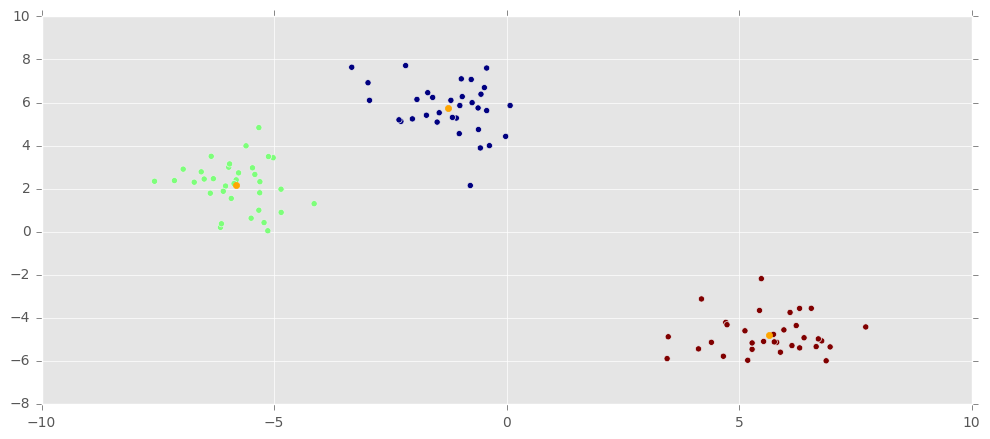

In [145]:
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=100, n_features=2, centers=3, cluster_std=1, 
           center_box=(-10.0, 10.0), shuffle=False, random_state=1234)
K = Kmeans(k = 3, max_iter = 100, eps = 0.0000001)
K = K.fit(X)
plt.scatter(X[:,0], X[:, 1], c=K.labels)
plt.scatter(K.centroids[:, 0], K.centroids[:, 1], color = 'orange')
K.iteration

# Применение K-means на реальных данных

Загрузите [данные](https://github.com/brenden17/sklearnlab/blob/master/facebook/snsdata.csv) в которых содержится описание интересов профилей учеников старшей школы США.

In [81]:
df_sns = pd.read_csv('Рабочий стол/Техносфера/Алгоритмы обработки данных./Лекция 2/snsdata.csv', sep=',')
df_sns.head()

,gradyear,gender,age,friends,basketball,football,soccer,softball,volleyball,swimming,...,blonde,mall,shopping,clothes,hollister,abercrombie,die,death,drunk,drugs
0,2006,M,18.982,7,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2006,F,18.801,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,2006,M,18.335,69,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,2006,F,18.875,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2006,NaN,18.995,10,0,0,0,0,0,0,...,0,0,2,0,0,0,0,0,1,1


Данные устроены так: 
* Год выпуска
* Пол
* Возраст
* Количество друзей
* 36 ключевых слов, которые встречаются в профилe facebook (интересы, сообщества, встречи)

#### Задание 3 (4 балла)

* Удалите все признаки кроме 36 ключевых слов.
* Нормализуйте данные - из каждого столбца вычтите его среднее значение и поделите на стандартное отклонение.
* Используйте метод k-means чтобы выделить 9 кластеров
* Попробуйте проинтерпретировать каждый кластер проанализировав полученные центройды (Некоторые кластеры могут быть очень большие и очень маленькие - плохо интерпретируются)

In [127]:
## Your Code Here
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
work_data = df_sns.loc[:,df_sns.columns[4:]]
work_data_scaled = min_max_scaler.fit_transform(work_data)
#work_data_scaled = preprocessing.scale(work_data)

    

In [136]:
K = Kmeans(k = 9, max_iter = 150, eps = 0.0001, zippate = 0.1)
K = K.fit(work_data_scaled)
work_labels = K.prediction(work_data_scaled)


1 / 150
2 / 150
3 / 150
4 / 150
5 / 150
6 / 150
7 / 150
8 / 150
9 / 150
10 / 150
11 / 150
12 / 150
13 / 150
14 / 150
15 / 150
16 / 150
17 / 150
18 / 150
19 / 150
20 / 150
21 / 150
22 / 150
23 / 150
24 / 150
25 / 150
26 / 150
27 / 150
28 / 150
29 / 150
30 / 150
31 / 150
32 / 150
33 / 150
34 / 150
35 / 150
36 / 150
37 / 150
38 / 150
39 / 150
40 / 150
41 / 150
42 / 150
43 / 150
44 / 150
45 / 150
46 / 150
47 / 150


In [138]:
# Количеств элементов в кластере
import collections
collections.Counter(K.labels)

Counter({0.0: 528,
         1.0: 17277,
         2.0: 1897,
         3.0: 708,
         4.0: 2084,
         5.0: 672,
         6.0: 1138,
         7.0: 4887,
         8.0: 809})

In [141]:
# Координаты центроидов.
for i in range(len(work_data.columns)):
    print((work_data.columns[i]))
    for j in range(9):
        print(j, " ", K.centroids[j][i])

basketball
0   0.0153882575758
1   0.00657183924678
2   0.0114874363029
3   0.0143596986817
4   0.0368881957774
5   0.0179191468254
6   0.018014059754
7   0.0108195211786
8   0.0225587144623
football
0   0.0231060606061
1   0.0052323898825
2   0.0145844315586
3   0.023352165725
4   0.112635956494
5   0.0335317460317
6   0.0198008201523
7   0.0110497237569
8   0.0296662546354
soccer
0   0.0094696969697
1   0.00607958771992
2   0.0105234385677
3   0.011247122829
4   0.0144309376555
5   0.0096450617284
6   0.0110004556402
7   0.0107162615859
8   0.0100260953166
softball
0   0.0109180035651
1   0.00314937574266
2   0.00945765760179
3   0.00938850116318
4   0.0624647171729
5   0.0128676470588
6   0.0111134084565
7   0.00699334368493
8   0.0173780266124
volleyball
0   0.01204004329
1   0.0040516293338
2   0.0102417350704
3   0.0193704600484
4   0.0549081436797
5   0.0141369047619
6   0.0109214160181
7   0.0100850653337
8   0.0143033727706
swimming
0   0.00421554252199
1   0.00283427342337
2 

In [144]:
for i in range(9):
    print(i, " _____________")
    for j in range(len(work_data.columns)):
        if (K.centroids[i][j] > work_data[work_data.columns[j]].mean() - 0.15* work_data[work_data.columns[j]].std()):
            print(K.centroids[i][j], " ", work_data.columns[j])

0  _____________
0.00413223140496   marching
0.00241046831956   bible
0.292929292929   dress
0.000388054860532   blonde
1  _____________
0.00373591795714   marching
0.00177850742185   bible
0.000134700302447   blonde
2  _____________
0.146810753822   hot
0.00297119854315   marching
0.00234820530023   bible
0.000382061487718   blonde
3  _____________
0.0116760828625   tennis
0.000770416024653   marching
0.00115562403698   bible
0.000647903384647   blonde
0.170747018205   hollister
0.14936440678   abercrombie
4  _____________
0.0624647171729   softball
0.0549081436797   volleyball
0.0358685220729   baseball
0.00440586285116   marching
0.00266096667248   bible
0.000497455493141   blonde
5  _____________
0.32457010582   cheerleading
0.00229978354978   marching
0.00257034632035   bible
0.000837337993301   blonde
0.0181878306878   hollister
0.0150669642857   abercrombie
6  _____________
0.00263620386643   marching
0.00135804441604   bible
0.000481019869614   blonde
0.230008787346   mall
0.00

Анализ кластеров.

1ый кластер - непонятно,
2ой кластер - непонятно,
3ий кластер - непонятно,
4ий кластер - скорее девушки (есть hot и blonde),
5ый кластер - спорт,
6ый кластер - скорее всего это девушки (есть чирлидинг,одежда и холестерин),
7ый кластер - тусовщики (есть магазины и наркотики),
8ой кластер - непонятно,
9ой кластер - еще более непонятно.